In [1]:
import sys
sys.path.append('..')
from dataset import ModisDataset, Sentinel5Dataset
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from model import Model, snapshot, restore
import ignite.metrics
import pandas as pd
from train import train_epoch, test_epoch, test_model, fine_tune
from visualizations import make_and_plot_predictions, predict_future
from dataset import transform_data
from copy import deepcopy

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

num_layers = 1
hidden_size = 128
region = "germany"
epochs = 5
include_time = True

N_seen_points = 227
N_predictions = 100

def criterion(y_pred, y_data, log_variances):
    norm = (y_pred-y_data)**2
    loss = (torch.exp(-log_variances) * norm).mean()
    regularization = log_variances.mean()
    return 0.5 * (loss + regularization)

def setup(smooth, smooth_method="mean"):
    model = Model(input_size=1 if not include_time else 2,
                  hidden_size=hidden_size,
                  num_layers=num_layers,
                  output_size=1,
                  device=device)

    #model.load_state_dict(torch.load("/tmp/model_epoch_0.pth")["model"])
    model.train()

    enddate = '2010-01-01'

    dataset = ModisDataset(region=region,
                           fold="train",
                           znormalize=True,
                           augment=False,
                           overwrite=False,
                           include_time=include_time,
                           filter_date=(None,enddate),
                           smooth=smooth,
                           smooth_method=smooth_method)

    testdataset = ModisDataset(region=region,
                           fold="test",
                           znormalize=True,
                           augment=False,
                           overwrite=False,
                           include_time=include_time,
                           filter_date=(None,None),
                           smooth=smooth,
                           smooth_method=smooth_method)

    validdataset = ModisDataset(region=region,
                                fold="validate",
                                znormalize=True,
                                augment=False,
                                include_time=include_time,
                                smooth=smooth,
                                smooth_method=smooth_method)

    #dataset = Sentinel5Dataset(fold="train", seq_length=300)
    #validdataset = Sentinel5Dataset(fold="validate", seq_length=300)

    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=512,
                                             shuffle=True,
                                             #sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(10000))
                                             )
    validdataloader = torch.utils.data.DataLoader(validdataset,
                                             batch_size=512,
                                             shuffle=False,
                                             #sampler=torch.utils.data.sampler.SubsetRandomSampler(np.arange(10000))
                                             )

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

    return model, dataset, testdataset, validdataset, dataloader, validdataloader, optimizer

../train.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
train_uptodate=2010-01-01 provided. removing all observations before 2010-01-01
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz
local dataset found at /tmp/germany.csv
loading cached dataset found at /tmp/germany.npz



epoch 0: train loss 0.20, test loss 0.17, mae=0.59, mse=0.57, rmse=0.75
saving model snapshot to /data2/igarss2020/models/LSTM_germany_l=1_h=128_e=0.pth



epoch 1: train loss 0.16, test loss 0.16, mae=0.59, mse=0.56, rmse=0.75
saving model snapshot to /data2/igarss2020/models/LSTM_germany_l=1_h=128_e=1.pth



epoch 2: train loss 0.15, test loss 0.16, mae=0.58, mse=0.56, rmse=0.75
saving model snapshot to /data2/igarss2020/models/LSTM_germany_l=1_h=128_e=2.pth



epoch 3: train loss 0.14, test loss 0.16, mae=0.58, mse=0.56, rmse=0.75
saving model snapshot to /data2/igarss2020/models/LSTM_germany_l=1_h=128_e=3.pth



epoch 4: train loss 0.12, test loss 0.15, mae=0.58, mse=0.55, rmse=0.74
saving model snapshot to /data2/igarss2020/models/LSTM_germany_l=1_h=128_e=4.pth


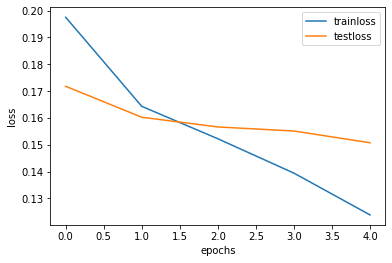

In [4]:
model, dataset, testdataset, validdataset, dataloader, validdataloader, optimizer = setup(None)

stats=list()
for epoch in range(epochs):
    trainloss = train_epoch(model,dataloader,optimizer, criterion, device)
    testmetrics, testloss = test_epoch(model,validdataloader,device, criterion, n_predictions=1)
    metric_msg = ", ".join([f"{name}={metric.compute():.2f}" for name, metric in testmetrics.items()])
    msg = f"epoch {epoch}: train loss {trainloss:.2f}, test loss {testloss:.2f}, {metric_msg}"
    print(msg)

    #test_model(model, validdataset, device)

    model_name = name_pattern.format(region=region, num_layers=num_layers, hidden_size=hidden_size, epoch=epoch)
    pth = os.path.join(model_dir, model_name+".pth")
    print(f"saving model snapshot to {pth}")
    snapshot(model, optimizer, pth)
    stat = dict()
    stat["epoch"] = epoch
    for name, metric in testmetrics.items():
        stat[name]=metric.compute()

    stat["trainloss"] = trainloss.cpu().detach().numpy()
    stat["testloss"] = testloss.cpu().detach().numpy()
    stats.append(stat)

df = pd.DataFrame(stats)

fig,ax = plt.subplots()
ax.plot(df.epoch, df.trainloss, label="trainloss")
ax.plot(df.epoch, df.testloss, label="testloss")
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('loss')

## Good Example
Likely represented well in the training dataset

saving to /home/marc/projects/igarss2020_tex/img/puyehoevolcano/puyehoevolcano


(<Figure size 1008x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d98e11c18>,
       dtype=object))

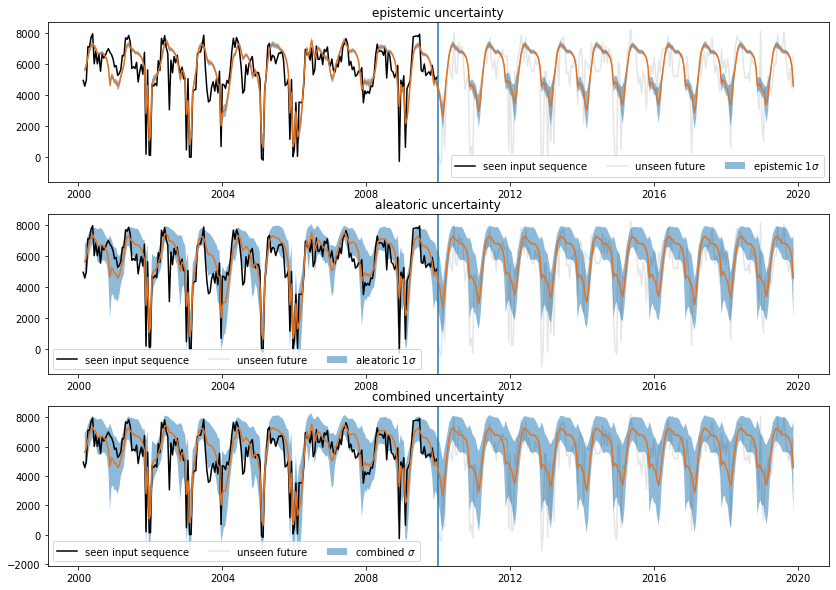

In [9]:
idx = 10

make_and_plot_predictions(model, testdataset.data[idx].astype(float), date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                              device=device,meanstd=(dataset.mean,dataset.std), store=store)

## Poor Example
Likely out-of-training-distribution. The model predicts systematilly to low values.

All model representations are affected equally. Hence, the epistemic model undertainty is underestimated 

saving to /home/marc/projects/igarss2020_tex/img/puyehoevolcano/puyehoevolcano


(<Figure size 1008x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d98c93208>,
       dtype=object))

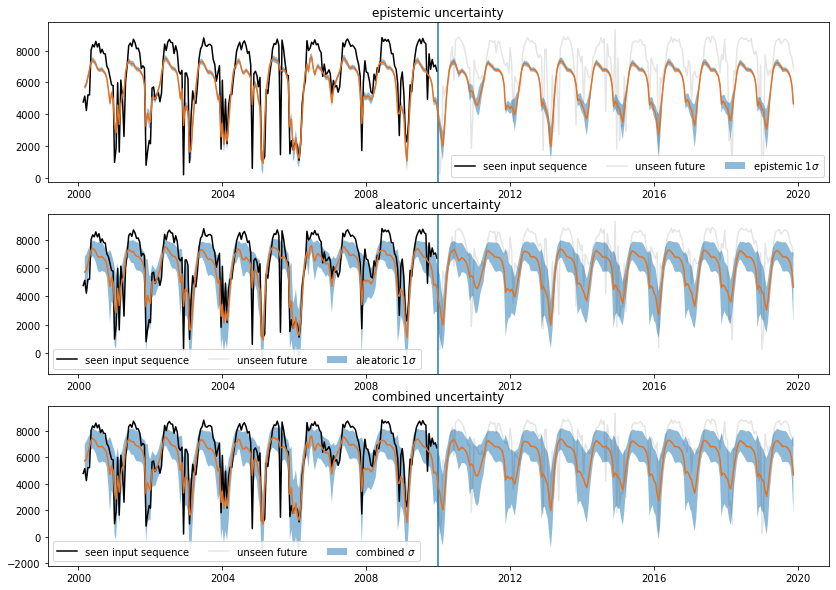

In [10]:
idx = 17

make_and_plot_predictions(model, testdataset.data[idx].astype(float), date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                              device=device,meanstd=(dataset.mean,dataset.std), store=store)

## Visualization of the "Default" Model

We only introduce a single time instance $t=0$ to see what representation the model learns in the absence of data

### The good example from above

saving to /home/marc/projects/igarss2020_tex/img/puyehoevolcano/puyehoevolcano


(<Figure size 1008x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d98a7a0f0>,
       dtype=object))

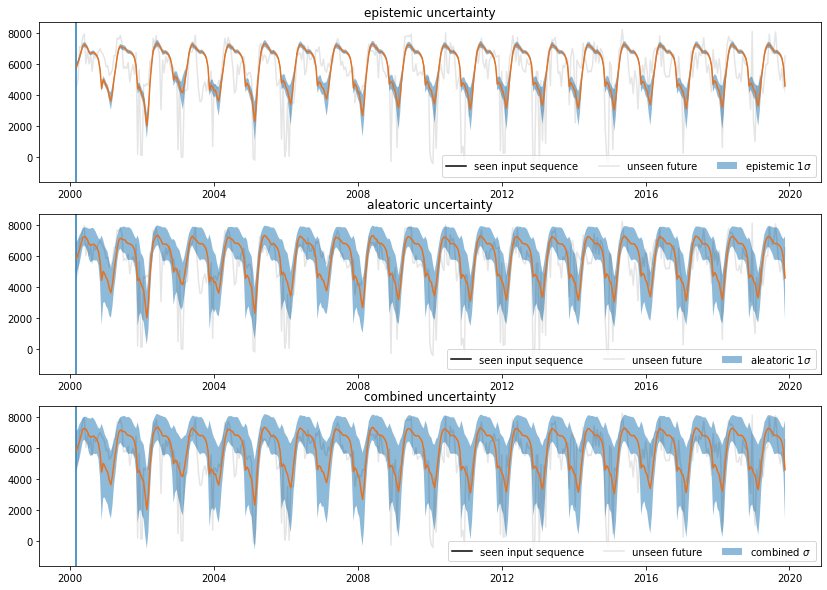

In [13]:
N_seen_points = 1
idx = 10
make_and_plot_predictions(model, testdataset.data[idx].astype(float), date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                              device=device,meanstd=(dataset.mean,dataset.std), store=store)

### The poor example from above


saving to /home/marc/projects/igarss2020_tex/img/puyehoevolcano/puyehoevolcano


(<Figure size 1008x720 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d988c12b0>,
       dtype=object))

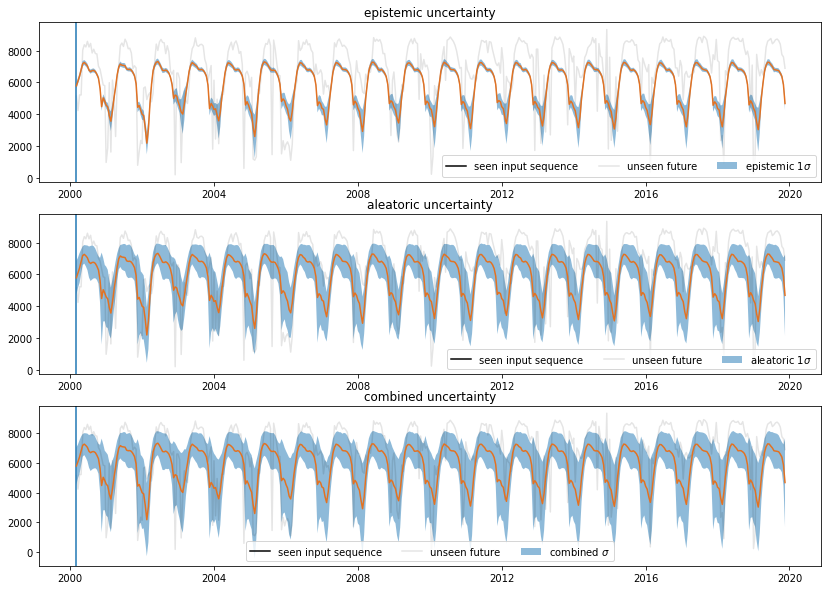

In [14]:
N_seen_points = 1
idx = 17
make_and_plot_predictions(model, testdataset.data[idx].astype(float), date, N_seen_points=N_seen_points, N_predictions=N_predictions,
                              device=device,meanstd=(dataset.mean,dataset.std), store=store)